In [31]:
import sys
import numpy as np
np.random.seed(0)
import torch
import itertools

# Create dataset

In [48]:
import numpy as np
import math
import ipympl
import matplotlib.pyplot as plt
import random

def create_dataset(xmin,xmax,N):

    A0 = 1.0
       
    T1 = 3
    phi1 = 2*math.pi/float(T1)
    A1 = 1/phi1
    
    T2 = 6
    phi2 = 2*math.pi/float(T2)
    A2 = 1/phi2
    
    xt = np.linspace(xmin, xmax, N)
    yt = np.zeros(xt.shape)
    for i in xrange(N):
        yt[i] = A0 + A1*math.sin(phi1*xt[i]) + A2*math.cos(phi2*xt[i])

    samples = np.random.normal(1,0.001,N/2)
    idx = random.sample(range(N), N/2)

    xs = np.zeros((N,2))
    xs[0:N/2,1] = yt[idx]+samples 
    xs[0:N/2,0] = xt[idx]
    nidx = np.setdiff1d(np.arange(0,N,1),idx)
    xs[N/2:N,1] = yt[nidx]-samples 
    xs[N/2:N,0] = xt[nidx]

    ys = np.zeros((N,))
    ys[0:N/2] = 1

    idx = random.sample(range(N), N/20)
    x = xs[idx,:]
    y = ys[idx]
    
    nidx = np.setdiff1d(np.arange(0,N,1),idx)
    tidx = random.sample(nidx, N/80)
    x_tst = xs[tidx,:]
    y_tst = ys[tidx]
    
    print(list(set(idx).intersection(tidx)))
    
        
    return x, y, xt, yt, x_tst, y_tst


def create_grid(xmin, xmax, N):
    """
    Creates a grid for 3d plotting.
    :param xmin: lower limit
    :param xmax: upper limit
    :param N: number of points in the grid per dimension
    :return: the grid
    """

    xx = np.linspace(xmin, xmax, N)
    X, Y = np.meshgrid(xx, xx)
    data = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

    return data, X, Y



def show_train_data():
    """
    Plots the training data.
    """
    xmin = -10.0
    xmax = 10.0
    N = 1000
    xs, ys, xt, yt, x_tst, y_tst = create_dataset(xmin,xmax,N)

    fig = plt.figure(figsize=(15,5)) 

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(xs[ys == 0, 0], xs[ys == 0, 1], 'b.', ms=12)
    ax1.plot(xs[ys == 1, 0], xs[ys == 1, 1], 'r.', ms=12)
    ax1.plot(xt,yt)
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_title('Training data')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(x_tst[y_tst == 0, 0], x_tst[y_tst == 0, 1], 'b.', ms=12)
    ax2.plot(x_tst[y_tst == 1, 0], x_tst[y_tst == 1, 1], 'r.', ms=12)
    ax2.plot(xt,yt)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_title('Test data')

    
    
    plt.show()
    
    return xs, ys, xt, yt, x_tst, y_tst

[]


<IPython.core.display.Javascript object>


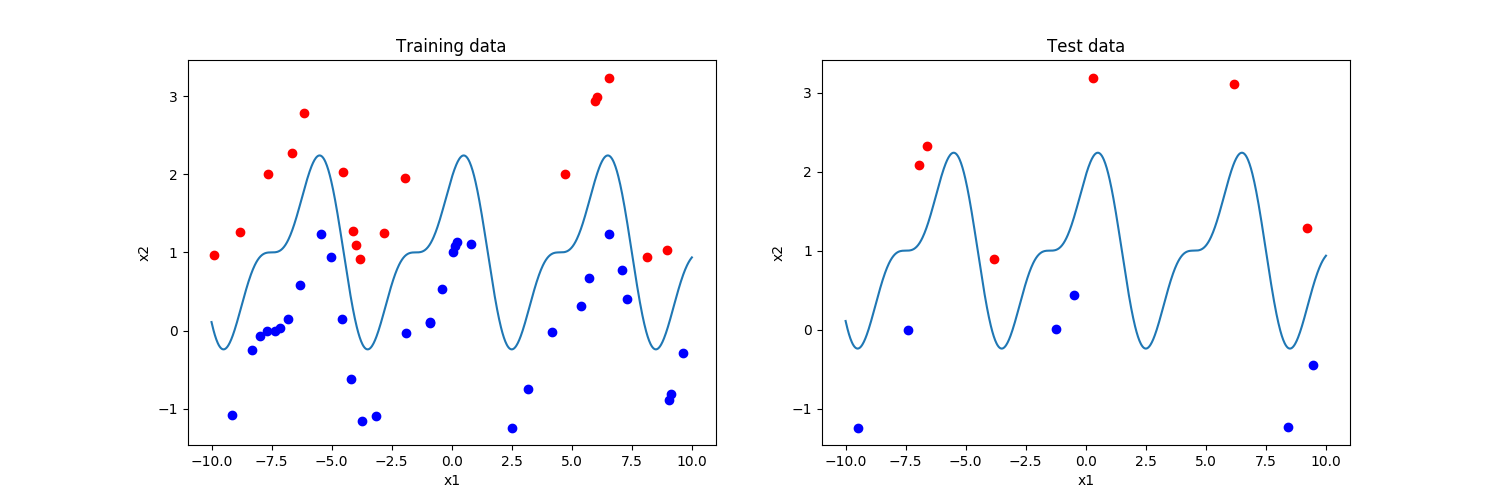

In [133]:
from sklearn.preprocessing import StandardScaler

nb_epochs = [300]
nb_reps = 5
K_test = 100
batch_size = 32
Q = 2 
l = 1e-6
D = 4

X_tr, Y_tr, xt, yt, x_tst_prescale, y_tst = show_train_data()

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
x_tst = scaler.transform(x_tst_prescale)

# Class implementing ConcreteDropout (Gal et al 2017)

In [134]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper, Concatenate


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers, not just `Dense`,
    for instance with a `Conv2D` layer:
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        input_dim = np.prod(input_shape[1:])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

# Plot helper

In [135]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

%matplotlib notebook

def plot_trainLoss(reps=None,train_loss=None):
    
   fig = plt.figure(figsize=(15,3)) 

   ax1 = fig.add_subplot(1, 2, 1)
   #Plot loss on training set    
   ax1.plot(reps, train_loss, c='r', label='Training')
   ax1.set_title('Loss')
   ax1.set_xlabel('x1')
   ax1.set_ylabel('x2')
   
   plt.show()
    
   return fig
    
    
    
def plot_testData(fig=None,add_fig=False,ax=None,xtest=None,ytest=None,xt=None,yt=None):
   
   if add_fig:
      fig = plt.figure(figsize=(15,3)) 
   
   if ax==None:
      ax = fig.add_subplot(1, 2, 2) 
    
   
   ax.plot(xt,yt)
   ax.plot(xtest[ytest == 0, 0], xtest[ytest == 0, 1], 'y.', ms=6)
   ax.plot(xtest[ytest == 1, 0], xtest[ytest == 1, 1], 'g.', ms=6)
   ax.set_title('Test data')
   ax.set_xlabel('x1')
   ax.set_ylabel('x2')
   

   plt.show()
   
   return fig, ax    


    
def plot_decisionSurface(preds=None,X=None,Y=None,xs=None,ys=None):

   #Plot decision surface
   ax2 = fig.add_subplot(1, 1, 1, projection='3d')
   Z = preds.reshape(list(X.shape))
   ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
   ax2.plot(xs[ys == 0, 0], xs[ys == 0, 1], 'b.', ms=8)
   ax2.plot(xs[ys == 1, 0], xs[ys == 1, 1], 'r.', ms=8)
   ax2.view_init(elev=90, azim=90)
   ax2.set_title('Decision surface')
   ax2.set_xlabel('x1')
   ax2.set_ylabel('x2')
   ax2.set_zlabel('y')
   
   plt.show()
    
    
    
    
def plot_results(results):
   
   loss = np.array([i[1] for i in results])
   drop_prob = np.array([i[0][0] for i in results])
   pred_entr = np.array([i[3] for i in results])


   fig = plt.figure(figsize=(10,4)) 

   ax1 = fig.add_subplot(1, 2, 1)
   #Plot ELBO vs predictive entropy    
   model = make_pipeline(PolynomialFeatures(3), Ridge())
   loss_plot = loss[:, np.newaxis]
   model.fit(loss_plot, pred_entr)

   x_plot = np.linspace(min(loss)-3, max(loss)+3, 1000)
   X_plot = x_plot[:, np.newaxis]

   y_plot = model.predict(X_plot)
   ax1.plot(x_plot, y_plot, color='teal', linewidth=2)
   ax1.scatter(loss[:], pred_entr[:], c='r', label='Training loss vs test predictive entropy') 
   ax1.set_title('Training loss vs test predictive entropy')
   ax1.set_xlabel('loss')
   ax1.set_ylabel('entropy')
   
   #Plot dropout probability vs predictive entropy
   ax2 = fig.add_subplot(1, 2, 2)
   model = make_pipeline(PolynomialFeatures(3), Ridge())
   drop_plot = drop_prob[:, np.newaxis]
   model.fit(drop_plot, pred_entr)

   x_plot = np.linspace(min(drop_prob)-3, max(drop_prob)+3, 100)
   X_plot = x_plot[:, np.newaxis]

   y_plot = model.predict(X_plot)
   ax2.plot(x_plot, y_plot, color='yellow', linewidth=2)

   ax2.scatter(drop_prob, pred_entr, c='r', label='Dropout probability vs test predictive entropy')
   ax2.set_title('Dropout probability vs test predictive entropy')
   ax2.set_xlabel('dropout prob')
   ax2.set_ylabel('entropy')
   

   plt.show()
    
    

# Training and testing functions

In [139]:
from keras.layers import Input,merge
from keras.models import Model


def fit_model(nb_epoch, X, Y, validation_data=None):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=(Q,))
    x = inp
    x = ConcreteDropout(Dense(3, activation='relu',name='CD1'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = Dense(1,activation='sigmoid',name='CD2')(x)
    
    out = x 
    model = Model(inp, out)
    
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 1  # a loss for each Concrete Dropout layer
    if validation_data==None:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0)    
    else:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_data=validation_data)
    loss = hist.history['loss'][-1]
    return hist,model, -0.5 * loss, hist.history['loss']   # return ELBO up to const.

In [140]:
def test(Y_true, MC_samples):
    
    assert len(MC_samples.shape) == 3
    
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    #Get probability of each class after MC sampling, so that we can get the mean
      
    MC_means = np.sum(MC_samples,axis=0)/float(k)
    y_pred = np.zeros((MC_samples.shape[1],1))
    y_pred[MC_means>=0.5] = 1   
    
    acc = len(np.where(Y_true==y_pred.flatten())[0])/float(N)*100
    print("\n ( Micro Averaging ) Accuracy: {}".format(acc))

    #For variation ratio
    predictions_per_test_point = np.zeros((k,N))
    for i in xrange(N):
        predictions_per_test_point[MC_samples[:,i,0]>=0.5,i] = 1
    
    mode_fx = []
    MC_majVote = np.zeros(y_pred.shape)
    for i in xrange(N):
        votes, values = np.unique(predictions_per_test_point[:,i], return_counts=True)
        m = np.argmax(votes)
        mode_fx.append((m,values[m]))
        MC_majVote[i] = m
    acc2 = len(np.where(MC_majVote.flatten()==Y_true)[0])/float(N)*100
    print("\n ( Macro Averaging ) Accuracy: {}".format(acc2))
    
          
    return acc, acc2, MC_means, MC_pred, mode_fx

        

# Training process

We estimate the following uncertainty metrics:

Variation ratio:
$$
VR = 1 - \frac{f_{mode}}{T}
$$
Predictive entropy:
$$
\hat{\mathcal{H}}[\,y\,|\,x, D_{train}\,]=-\sum_c\Big(\frac{1}{T}\sum_tp(\,y=c\,|\,x,\hat{\omega_t}\,)\Big)\log\Big(\frac{1}{T}\sum_tp(\,y=c\,|\,x,\hat{\omega_t}\,)\Big)
$$
Mutual Information:
$$
\hat{\mathcal{I}}[\,y,\omega|x,D_{train}\,]= -\sum_c\Big(\frac{1}{T}\sum_tp(\,y=c
\,|\,x,\hat{\omega_t}\,)\Big)\log\Big(\frac{1}{T}\sum_tp(\,y=c\,|\,x,\hat{\omega_t}\,)\Big)+\\ \frac{1}{T}\sum_{c,t}p(\,y=c\,|\,x,\hat{\omega_t}\,)\log p(\,y=c\,|\,x,\hat{\omega_t}\,)
$$


<IPython.core.display.Javascript object>


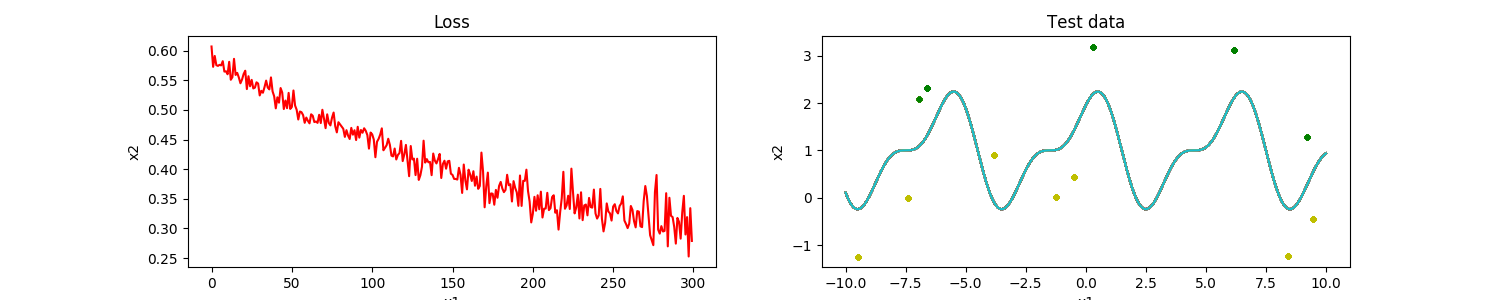


 ( Micro Averaging ) Accuracy: 91.6666666667

 ( Macro Averaging ) Accuracy: 91.6666666667
0.03833333333333332
0.2201656699180603
0.21815768599510194


<IPython.core.display.Javascript object>


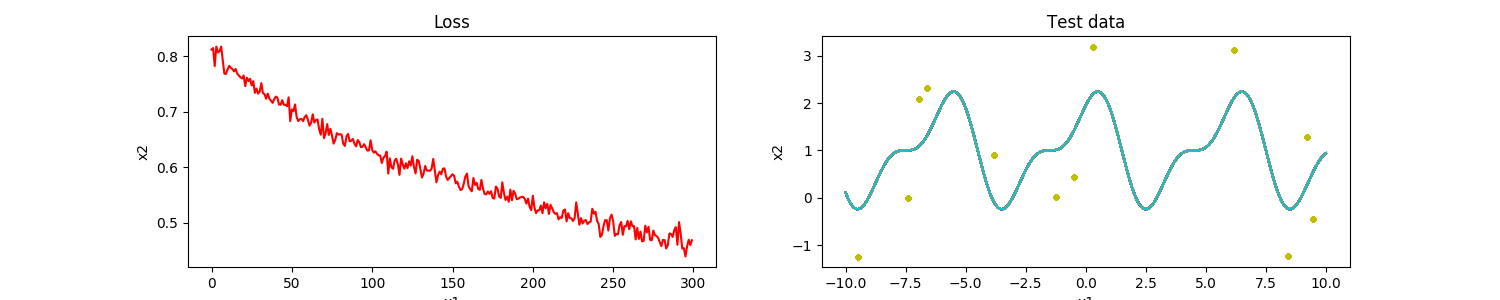


 ( Micro Averaging ) Accuracy: 50.0

 ( Macro Averaging ) Accuracy: 50.0
0.0
0.33244170745213825
0.3291846257448196


<IPython.core.display.Javascript object>


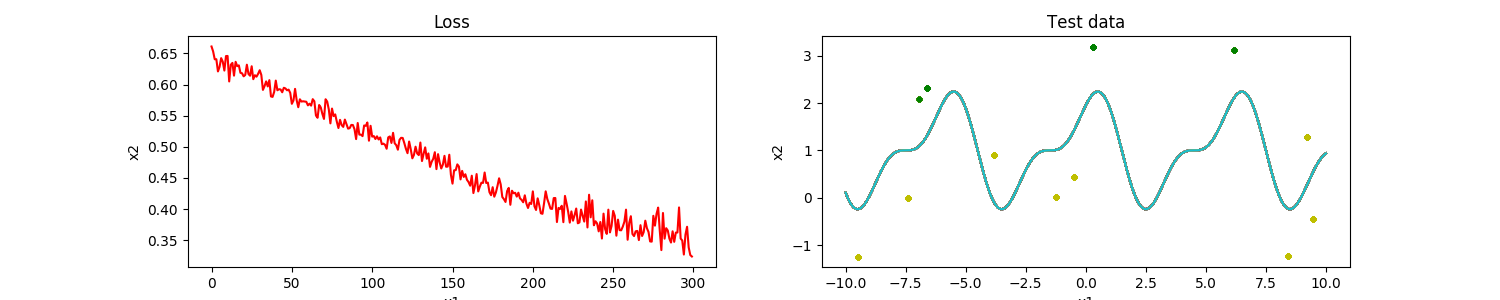


 ( Micro Averaging ) Accuracy: 83.3333333333

 ( Macro Averaging ) Accuracy: 91.6666666667
0.11333333333333333
0.2615446050961812
0.25918547550837195


<IPython.core.display.Javascript object>


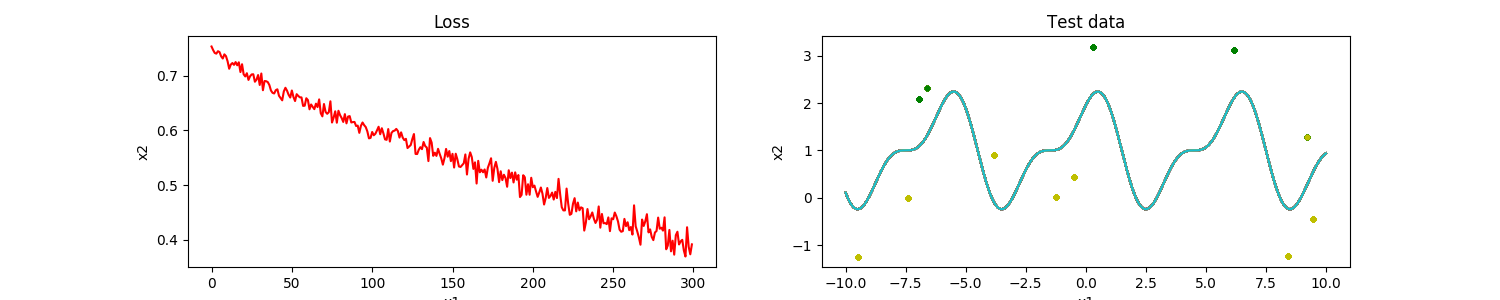


 ( Micro Averaging ) Accuracy: 91.6666666667

 ( Macro Averaging ) Accuracy: 91.6666666667
0.06250000000000001
0.28733078638712567
0.28450695355733235


<IPython.core.display.Javascript object>


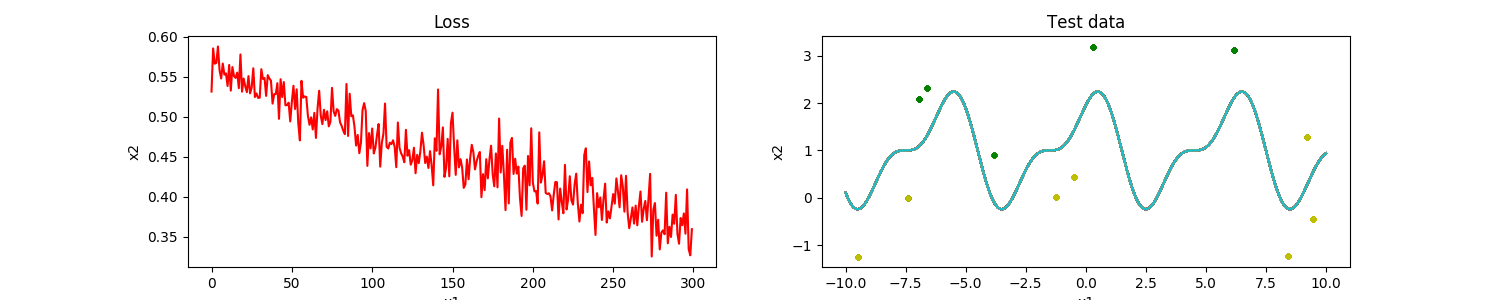


 ( Micro Averaging ) Accuracy: 83.3333333333

 ( Macro Averaging ) Accuracy: 83.3333333333
0.2808333333333333
0.2281286915143331
0.22604732831319174


<IPython.core.display.Javascript object>


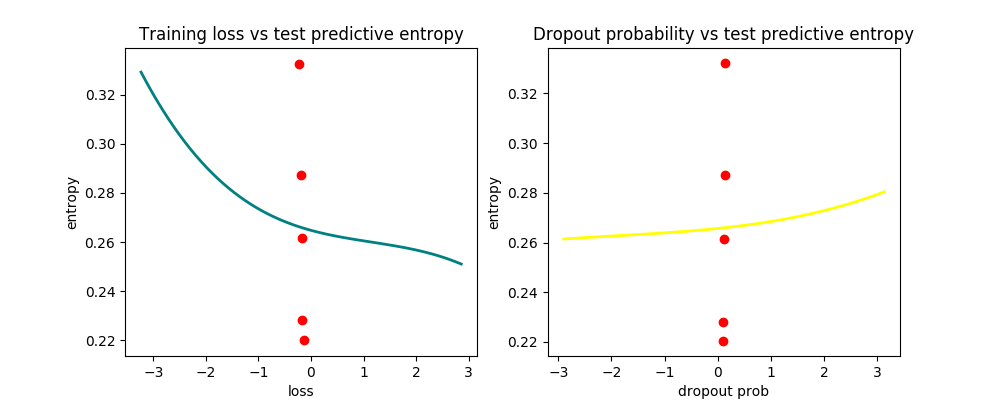

In [141]:
results = []

# get results for multiple N
#for N, nb_epoch in zip(Ns, nb_epochs):
for nb_epoch in nb_epochs:
       
    # repeat exp multiple times
    rep_results = []
    for i in xrange(nb_reps):
        X_train, Y_train = X_tr, Y_tr
        hist, model, ELBO_final, loss = fit_model(nb_epoch, X_train, Y_train) 
        #percentage of neurons kept active
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
        fig = plot_trainLoss(reps=range(nb_epoch),train_loss=loss)

        MC_samples_complete = []
        ax = None
        for _ in range(K_test):
            MC_samples = model.predict(x_tst)
            ytest = np.zeros((len(MC_samples),1))
            MC_samples_complete += [MC_samples]
            for i in xrange(len(MC_samples)):
                if MC_samples[i]>=0.5:
                   ytest[i] = 1
            fig, ax = plot_testData(fig=fig,add_fig=False,ax=ax,xtest=x_tst_prescale,ytest=ytest.flatten(),xt=xt,yt=yt)
        
            """
            #Data to plot decision surface - RESAMPLED NETWORK, NOT SAME AS TEST PREDICTION!!
            meshgrid_data,X,Y = create_grid(-10,10,100)
            grid_data = model.predict(meshgrid_data)
            plot_decisionSurface(preds=grid_data,X=X,Y=Y,xs=X_tr,ys=Y_tr)
            """
        

        acc, acc_maj_vote, MC_means, MC_pred, mode_fx = test(y_tst, np.array(MC_samples_complete)) 
        #Average variation ratio over the minibatch
        variation_ratio = np.zeros(MC_pred.shape)
        for j in xrange(len(MC_pred)):
            variation_ratio[j] = 1 - ((mode_fx[j])[1])/float(K_test)
        variation_ratio_avg_VR = np.sum(variation_ratio)/float(len(MC_pred))
        print(variation_ratio_avg_VR)
       
        #Average predictive entropy over minibatch
        predictive_entropy = -1*np.sum(MC_means*np.log(MC_means),axis=-1)
        predictive_entropy_avg_H = np.sum(predictive_entropy)/float(len(MC_pred))
        print(predictive_entropy_avg_H)
        
        #Average mutual information over minibatch
        expected_entropy = np.sum(np.sum(MC_samples*np.log(MC_samples),axis=-1),axis=0)/float(K_test)
        mutual_information_avg_MI = predictive_entropy_avg_H + np.sum(expected_entropy)/float(len(MC_pred))
        print(mutual_information_avg_MI)
        
        rep_results += [(ps,ELBO_final,variation_ratio_avg_VR,predictive_entropy_avg_H,mutual_information_avg_MI)]
    plot_results(rep_results) 
                   
    

